In [807]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np


In [809]:
df = pd.read_csv('all_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [810]:
df

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,silver_Change %,dollar_rate_Price,dollar_rate_Open,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,m1sl_M1SL,is_holiday
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,NaN,80.03,80.21,80.24,80.10,0.00,234.100,201.200,2638.8,1
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,3.91,80.63,80.12,80.71,80.08,0.75,234.100,201.200,2638.8,0
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,0.41,80.79,80.57,80.89,80.49,0.20,234.100,201.200,2638.8,0
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,-0.53,80.65,80.86,80.91,80.54,-0.17,234.100,201.200,2638.8,0
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,-1.57,80.83,80.69,80.95,80.60,0.22,234.100,201.200,2638.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,75.56,77.28,77.69,75.52,365120.0,-2.21,233.449997,233.500000,232.059998,232.759995,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-27,75.56,77.28,77.69,75.52,365120.0,-2.21,231.690002,233.470001,231.570007,233.389999,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-28,75.56,77.28,77.69,75.52,365120.0,-2.21,232.000000,232.020004,230.729996,231.750000,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0


Data Preprocessing - checking correlation and cointegration

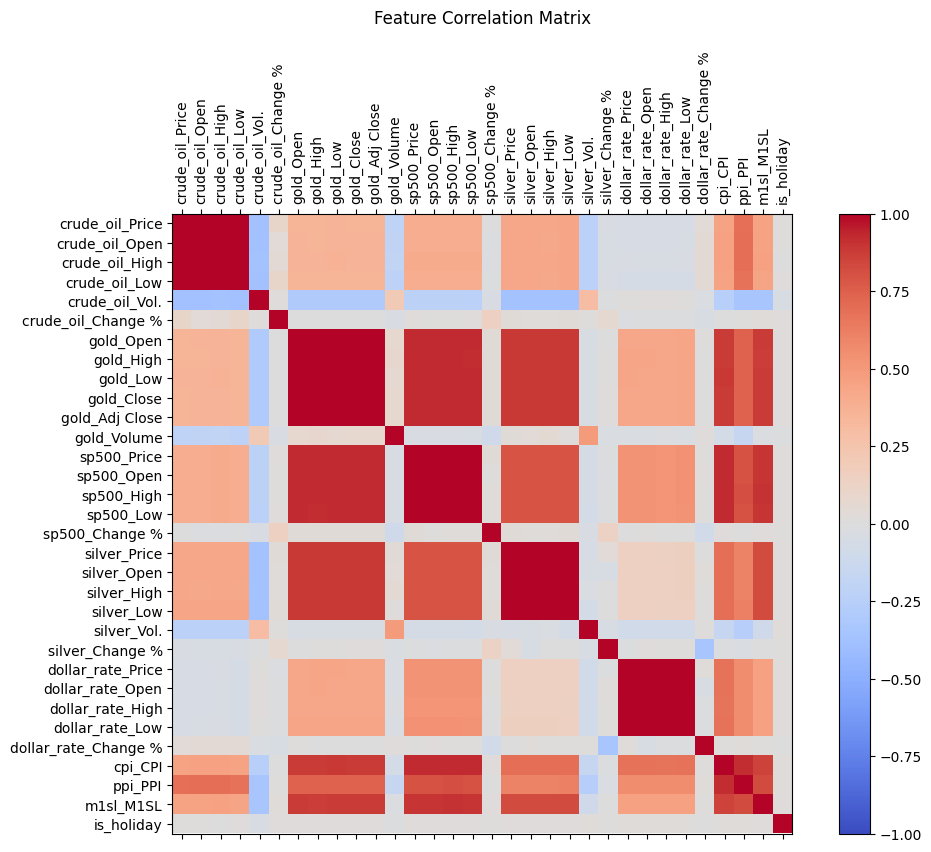

In [811]:
import matplotlib.pyplot as plt

def plot_corr_matrix(df):
    correlation_matrix = df.corr()
    
    # Plotting the correlation matrix with Matplotlib
    plt.figure(figsize=(12, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    
    # Set tick labels for the correlation matrix
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    
    # Annotate each cell with the numeric value of the correlation
    """for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    """
    plt.title("Feature Correlation Matrix", pad=20)
    plt.show()

plot_corr_matrix(df)

In [813]:
# adding columns to predict - dependent on number of days
#df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]

num_days = 30 # Number of days to predict
# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
df = df.dropna()
# Separate features and targets
# filter df to leave only 1 column of each type
X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_dropped = X_train.dropna()
#print(len(X_train_dropped))
y_train_dropped = y_train.loc[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]

X

/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/2526710444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'target_day_{i}'] = df['gold_Close'].shift(-i)
/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/2526710444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'target_day_{i}'] = df['gold_Close'].shift(-i)
/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/2526710444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,gold_Close,silver_Price,sp500_Price,crude_oil_Price,gold_price_yesterday,gold_price_2days,gold_price_3days,cpi_CPI,ppi_PPI,m1sl_M1SL,dollar_rate_Price,is_holiday
Date,,,,,,,,,,,,
2014-01-07,118.820000,19.787,1837.90,93.67,119.500000,119.290001,118.000000,234.100,201.200,2638.8,80.83,0
2014-01-08,118.120003,19.539,1837.50,92.33,118.820000,119.500000,119.290001,234.100,201.200,2638.8,81.02,0
2014-01-09,118.459999,19.683,1838.10,91.66,118.120003,118.820000,119.500000,234.100,201.200,2638.8,81.00,0
2014-01-10,120.260002,20.223,1842.40,92.72,118.459999,118.120003,118.820000,234.100,201.200,2638.8,80.66,0
2014-01-13,121.019997,20.385,1819.20,91.80,120.260002,118.459999,118.120003,234.100,201.200,2638.8,80.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16,228.289993,31.458,5667.20,80.76,223.830002,223.110001,223.250000,313.207,256.772,17978.9,104.27,0
2024-07-17,227.229996,30.377,5588.27,82.85,228.289993,223.830002,223.110001,313.207,256.772,17978.9,103.75,0
2024-07-18,225.779999,30.224,5544.59,82.82,227.229996,228.289993,223.830002,313.207,256.772,17978.9,104.17,0


In [857]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Number of days to predict
num_days = 30  

# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
df = df.dropna()

# Separate features and targets
X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on X_train and transform X_train and X_test
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X.columns, index=X_test.index)

# Fit the scaler on y_train and transform y_train and y_test
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train), columns=y.columns, index=y_train.index)
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test), columns=y.columns, index=y_test.index)

# Drop NaNs from scaled train sets (ensures rows align with shifted target data)
X_train_scaled_dropped = X_train_scaled.dropna()
y_train_scaled_dropped = y_train_scaled.loc[X_train_scaled_dropped.index]

# Drop NaNs from scaled test sets and ensure alignment
X_test_scaled_dropped = X_test_scaled.dropna()
y_test_scaled_dropped = y_test_scaled.loc[X_test_scaled_dropped.index]

# Ensure indices match for test data after NaN drops
common_index = X_test_scaled_dropped.index.intersection(y_test_scaled_dropped.index)
X_test_dropped = X_test_scaled_dropped.loc[common_index]
y_test_dropped = y_test_scaled_dropped.loc[common_index]

In [858]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# Apply RFE
selector = RFE(model, n_features_to_select=10)  # Choose how many features to select
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# Train model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)

# Evaluate the model
rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)

Selected features: Index(['gold_Close', 'silver_Price', 'crude_oil_Price', 'gold_price_yesterday',
       'gold_price_2days', 'gold_price_3days', 'cpi_CPI', 'ppi_PPI',
       'dollar_rate_Price', 'is_holiday'],
      dtype='object')


/Library/Python/3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [859]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Fit the MultiOutputRegressor
model = MultiOutputRegressor(LinearRegression())
#model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Initialize list to hold summary data for each target day
summary_data = []

# Extract feature names from X_train_dropped
feature_names = X_train_dropped.columns

# For each target day, get the model's coefficients, intercept, and performance metrics
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    intercept = estimator.intercept_
    
    # Calculate predictions and performance metrics
    y_pred = estimator.predict(X_train_dropped)
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)

    # Create a DataFrame for the day's coefficients with metrics included
    day_summary = pd.DataFrame({
        'Coefficient': coefficients,
        'Intercept': intercept,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
    })
    summary_data.append(day_summary)

# Concatenate all day summaries into a single DataFrame for display
summary_df = pd.concat(summary_data, keys=[f'Target Day {i+1}' for i in range(len(summary_data))])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show the full summary with feature names and coefficients
print("Detailed Coefficients Summary for Each Target Day:")
#print(summary_df)

# Reset display options to default after viewing if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
summary_df

Detailed Coefficients Summary for Each Target Day:


Coefficient  Intercept        MSE  \
Target Day 1  gold_Close               1.017896   4.597807   1.469697   
              silver_Price            -0.111489   4.597807   1.469697   
              sp500_Price              0.000051   4.597807   1.469697   
              crude_oil_Price          0.005277   4.597807   1.469697   
              gold_price_yesterday    -0.032425   4.597807   1.469697   
...                                         ...        ...        ...   
Target Day 30 cpi_CPI                 -0.004907  75.742802  28.664759   
              ppi_PPI                 -0.177554  75.742802  28.664759   
              m1sl_M1SL                0.000618  75.742802  28.664759   
              dollar_rate_Price       -0.277462  75.742802  28.664759   
              is_holiday               0.509396  75.742802  28.664759   

                                        RMSE       R^2  
Target Day 1  gold_Close            1.212311  0.997385  
              silver_Price          1.212311  0.997385  
              sp500_Price           1.212311  0.997385  
              crude_oil_Price       1.212311  0.997385  
              gold_price_yesterday  1.212311  0.997385  
...                                      ...       ...  
Target Day 30 cpi_CPI               5.353948  0.949763  
              ppi_PPI               5.353948  0.949763  
              m1sl_M1SL             5.353948  0.949763  
              dollar_rate_Price     5.353948  0.949763  
              is_holiday            5.353948  0.949763  

[360 rows x 5 columns]

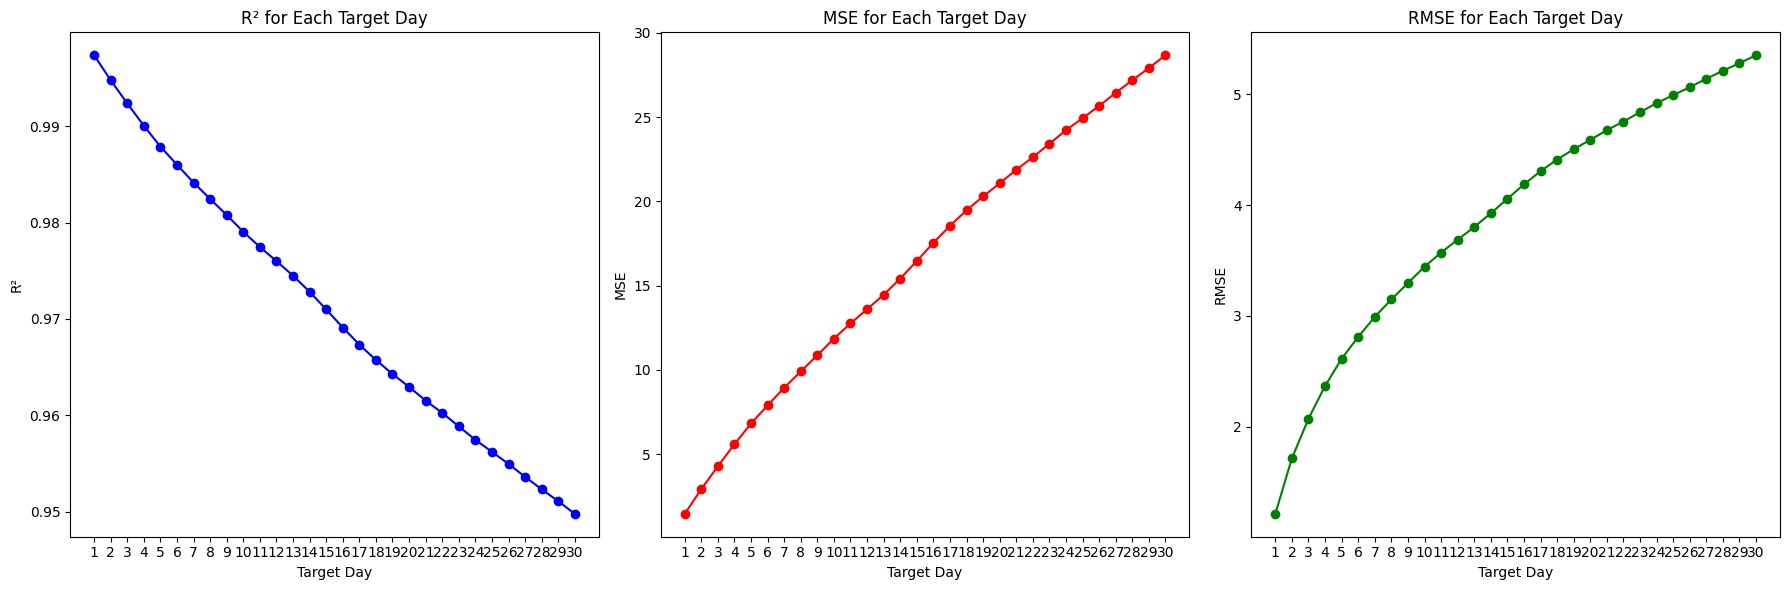

In [860]:
import matplotlib.pyplot as plt

# Initialize lists to store performance metrics for each target day
r2_scores = []
mse_values = []
rmse_values = []

# Extract metrics for each target day
for day_index, estimator in enumerate(model.estimators_):
    # Calculate predictions
    y_pred = estimator.predict(X_train_dropped)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)
    
    # Append metrics to the respective lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    r2_scores.append(r2)

# Create a DataFrame to hold the metrics for each target day
metrics_df = pd.DataFrame({
    'Target Day': [f'{i+1}' for i in range(len(r2_scores))],
    'R^2': r2_scores,
    'MSE': mse_values,
    'RMSE': rmse_values
})

# Set plot size
plt.figure(figsize=(18, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(metrics_df['Target Day'], metrics_df['R^2'], color='blue', marker='o')
plt.title('R² for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('R²')

# Plot MSE
plt.subplot(1, 3, 2)
plt.plot(metrics_df['Target Day'], metrics_df['MSE'], color='red', marker='o')
plt.title('MSE for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('MSE')

# Plot RMSE
plt.subplot(1, 3, 3)
plt.plot(metrics_df['Target Day'], metrics_df['RMSE'], color='green', marker='o')
plt.title('RMSE for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('RMSE')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


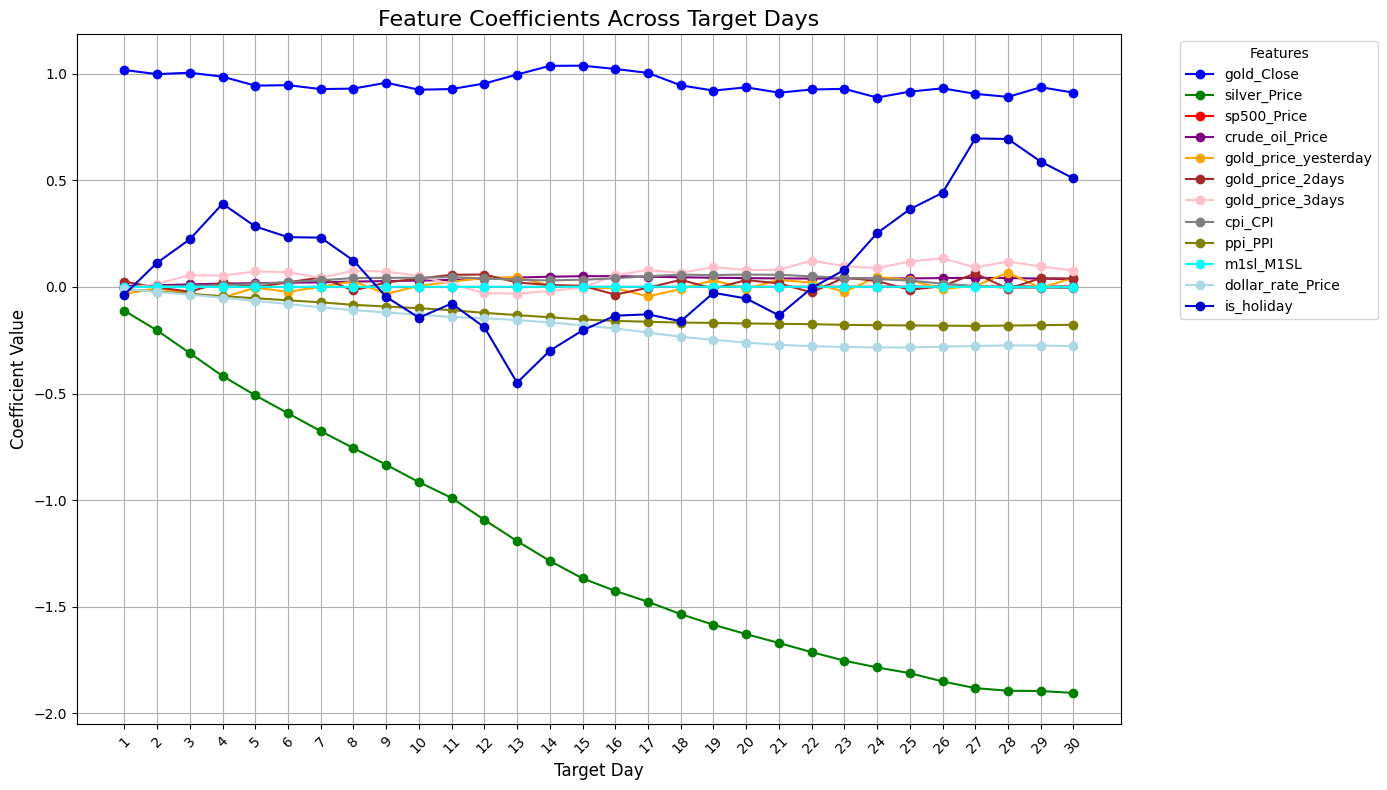

In [869]:
import matplotlib.pyplot as plt

# Create a DataFrame to store the coefficients for each target day
coefficients_df = pd.DataFrame()

# Loop through each day's model and extract the coefficients for the relevant features
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    
    # Add the coefficients for the target day to the DataFrame
    coefficients_df[f'{day_index + 1}'] = coefficients

# Plot the coefficients for each feature across target days
plt.figure(figsize=(14, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lightblue', 'mediumblue', 'teal', 'dodgerblue']  # Add more colors if needed
# Loop over the rows (features) and plot them
i=0
for feature in coefficients_df.index:
    plt.plot(coefficients_df.columns, coefficients_df.loc[feature, :], label=feature, color = colors[i], marker='o')
    i+=1

# Add labels and title
plt.title('Feature Coefficients Across Target Days', fontsize=16)
plt.xlabel('Target Day', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [851]:
import matplotlib.pyplot as plt
import pandas as pd
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results(predictions, num_of_days=6):
    # Extract the actual values for the test period (y_test_dropped)
    actual_values = y_test_dropped.iloc[:, 0].values  # Assuming first column has actual values (e.g., 'target_day_1')
    actual_dates = y_test_dropped.index
    # Prepare lists for concatenating predicted values and corresponding dates
    predicted_values = []
    predicted_dates = []
    predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, 
                                  columns=[f'predicted_day_{i+1}' for i in range(predictions.shape[1])])

    # Create the plot for actual values
    plt.figure(figsize=(14, 6))
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)
    true_values_length = len(y_test_dropped)
    # Loop through the predictions and plot them in chunks of `num_of_days`
    for i in range(0, len(predictions_df), num_of_days):
        # Check if this chunk is smaller than num_of_days
        end_index = min(i + num_of_days, len(predictions_df))
        #print(end_index)
        # Take the current chunk, ensuring we don't go out of bounds
        predicted_chunk = predictions_df.iloc[i, :num_of_days]  # Grab the chunk (first row if it's the first row)
        #print(predicted_chunk)
        # Add to the list of predicted values
        predicted_values.extend(predicted_chunk.values.flatten())  # Flatten to avoid nested lists
        predicted_dates.extend(y_test_dropped.index[i:end_index])
    predicted_values = predicted_values[:true_values_length]
    predicted_dates = predicted_dates[:true_values_length]
    # Plot the predicted values as a single line
    plt.plot(predicted_dates, predicted_values, label='Predicted Gold Price', color='red', linestyle='--', linewidth=2)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for the Next {num_of_days} Days, RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.show()


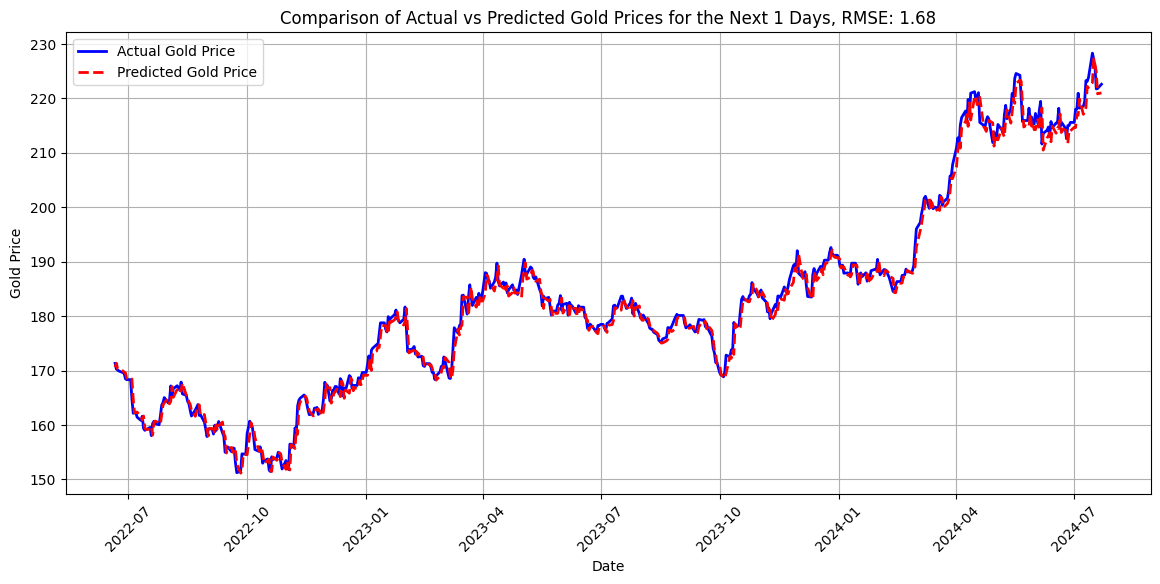

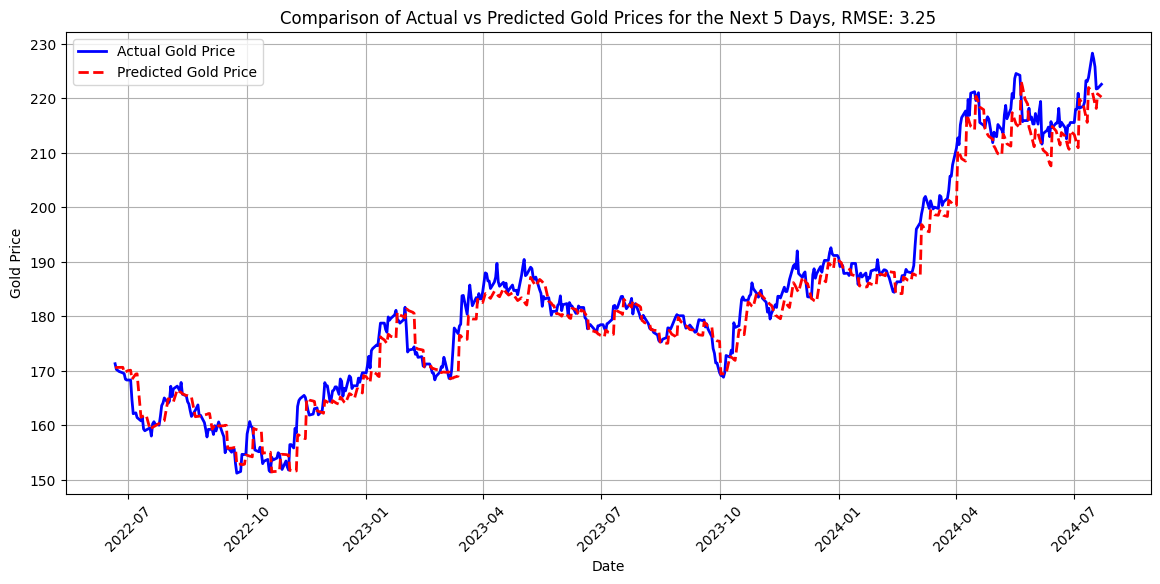

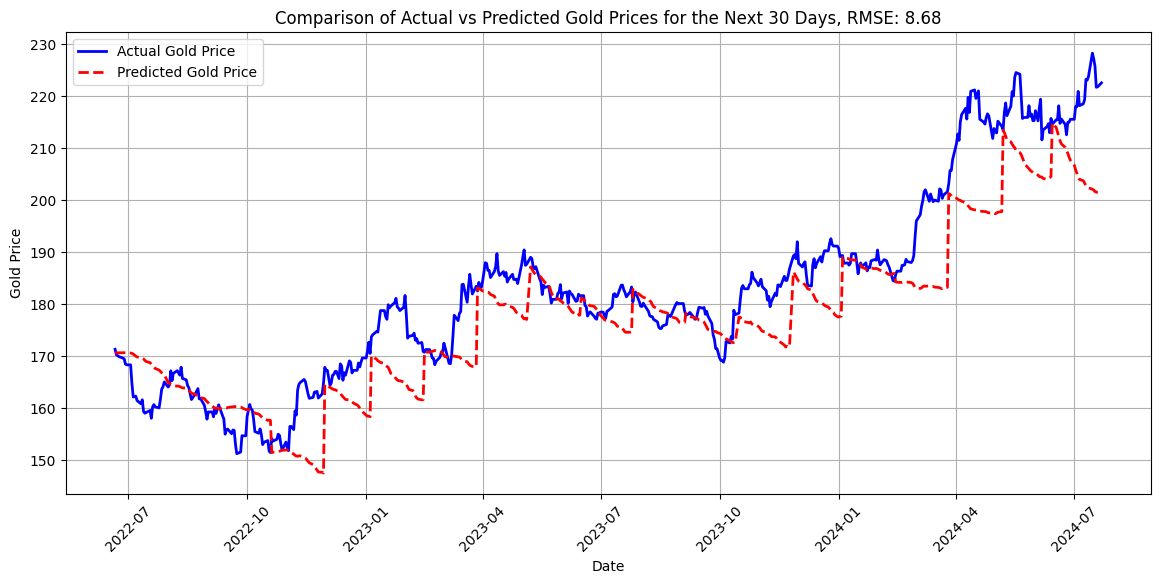

In [852]:
plot_results(predictions, num_of_days=1)
plot_results(predictions, num_of_days=5)
plot_results(predictions, num_of_days=30)

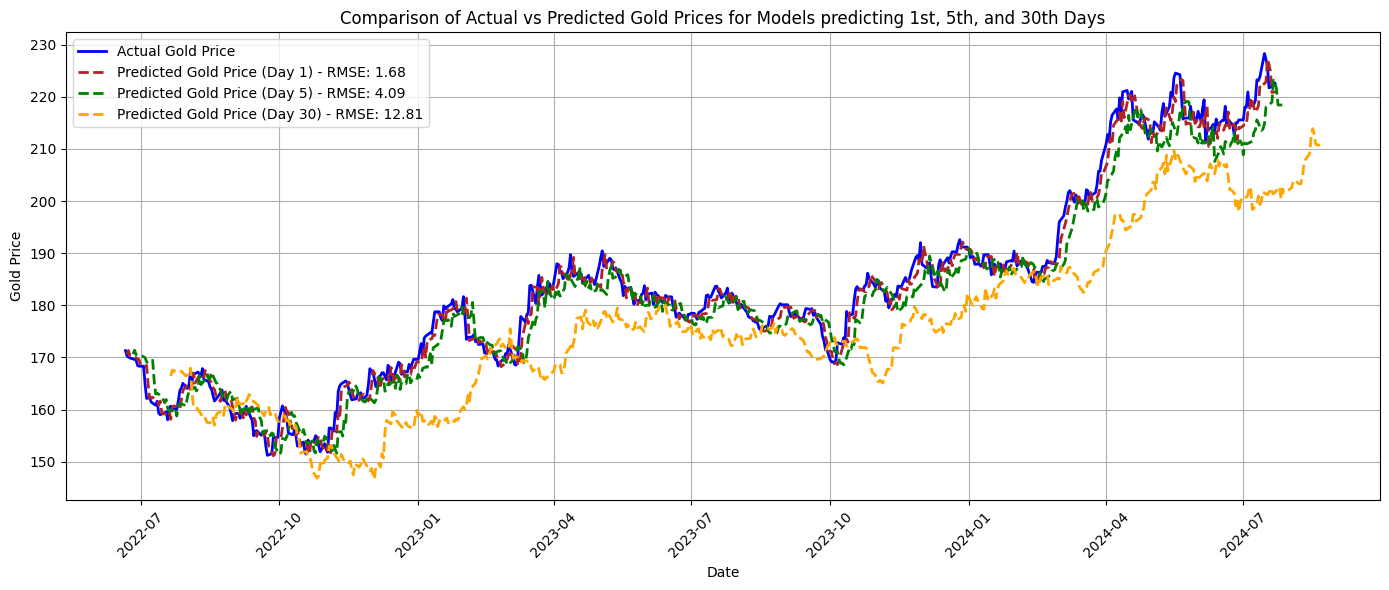

In [853]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Function to compute RMSE
def calculate_rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

# Assuming model and predictions are already trained and predicted
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results_per_model(predictions, model_numbers=[1, 5, 30]):
    # Prepare lists for actual and predicted values
    plt.figure(figsize=(14, 6))

    # Actual values (same for all target days)
    actual_values = y_test_dropped.iloc[:, 0].values  # Assuming the first column is the actual values
    actual_dates = y_test_dropped.index
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)

    # Color choices for different target days
    colors = ['#B22222', 'green', 'orange']
    i = 0

    # Plot the predicted values for each target day (1, 5, 30)
    for model_number in model_numbers:
        predicted_values = predictions[:, model_number - 1]  # Get the predictions for the target day (model_number)
        
        # Shift the predicted dates by the number of days in model_number
        shifted_dates = y_test_dropped.index + pd.Timedelta(days=model_number)  # Shift dates forward by model_number days

        # Calculate RMSE for the current model's predictions
        rmse = calculate_rmse(y_test_dropped.iloc[:, model_number - 1].values, predicted_values)
        
        # Plot the predicted values for this model_number
        plt.plot(shifted_dates, predicted_values, linestyle='--', color=colors[i], 
                 label=f'Predicted Gold Price (Day {model_number}) - RMSE: {rmse:.2f}', linewidth=2)
        i += 1

    # Title and labels for the plot
    plt.title('Comparison of Actual vs Predicted Gold Prices for Models predicting 1st, 5th, and 30th Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call the function for the target days you want to plot (e.g., Day 1, Day 5, Day 30)
plot_results_per_model(predictions, model_numbers=[1, 5, 30])

In [854]:
import pandas as pd

def create_predictions_df(predictions, num_of_days=30):
    # Initialize an empty list to store concatenated predictions
    predictions_list = []
    
    # Loop over each target day (i.e., column in predictions)
    for i in range(predictions.shape[1]):
        # For each target day, collect predictions by jumping `num_of_days`
        day_predictions = []
        for j in range(0, len(predictions), num_of_days):
            end_index = min(j + num_of_days, len(predictions))
            day_predictions.extend(predictions[j:end_index, i])  # Concatenate predictions
            
        predictions_list.append(day_predictions)
    
    # Convert the concatenated predictions list to a DataFrame
    predictions_df = pd.DataFrame(predictions_list).transpose()
    
    # Set column names for target days (target_day_1, target_day_2, ...)
    predictions_df.columns = [f'target_day_{i+1}' for i in range(predictions.shape[1])]
    
    return predictions_df

# Now, we can create the predictions DataFrame
predictions_df = create_predictions_df(predictions, num_of_days=30)

# Display the predictions DataFrame
print(predictions_df)

# Display the predictions DataFrame
predictions_df


     target_day_1  target_day_2  target_day_3  target_day_4  target_day_5  \
0      170.597705    170.622763    170.630489    170.635950    170.646418   
1      171.327642    171.346974    171.396434    171.426416    171.403689   
2      170.252594    170.352918    170.419728    170.458144    170.551280   
3      170.151574    170.195120    170.252367    170.348709    170.372426   
4      169.939906    170.031309    170.145789    170.207823    170.273214   
..            ...           ...           ...           ...           ...   
562    227.270469    226.299557    225.311458    224.182477    223.185464   
563    226.198201    225.457453    224.465768    223.435010    222.784044   
564    224.874264    224.036737    223.016023    222.237345    221.518799   
565    220.826896    220.232790    219.505801    218.863574    218.434024   
566    220.999876    220.311631    219.664849    219.034817    218.422310   

     target_day_6  target_day_7  target_day_8  target_day_9  target_day_10 

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5,target_day_6,target_day_7,target_day_8,target_day_9,target_day_10,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
0,170.597705,170.622763,170.630489,170.635950,170.646418,170.652519,170.687526,170.728631,170.650990,170.598039,...,168.744363,168.426493,168.120221,167.879612,167.622429,167.308824,167.040006,166.801175,166.616964,166.449735
1,171.327642,171.346974,171.396434,171.426416,171.403689,171.447428,171.479395,171.520874,171.518601,171.439549,...,169.804116,169.521706,169.255679,168.953745,168.732750,168.461049,168.169019,167.887870,167.791133,167.591179
2,170.252594,170.352918,170.419728,170.458144,170.551280,170.587499,170.661553,170.774984,170.703242,170.698994,...,169.376526,169.121232,168.798887,168.617143,168.400733,168.097139,167.823832,167.661573,167.447292,167.321246
3,170.151574,170.195120,170.252367,170.348709,170.372426,170.442589,170.522668,170.543132,170.565890,170.562731,...,169.287396,169.008713,168.822471,168.591297,168.358560,168.133575,167.949143,167.680900,167.590473,167.441416
4,169.939906,170.031309,170.145789,170.207823,170.273214,170.324816,170.367382,170.477012,170.466038,170.432932,...,169.208930,168.999571,168.726571,168.499255,168.324675,168.092555,167.815960,167.628127,167.467876,167.296007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,227.270469,226.299557,225.311458,224.182477,223.185464,222.421492,221.577898,220.896865,220.302304,219.428610,...,212.860662,212.691038,212.445801,212.145778,212.214156,212.119039,211.903728,212.049507,212.497390,212.577451
563,226.198201,225.457453,224.465768,223.435010,222.784044,222.057042,221.464607,220.957287,220.187446,219.627901,...,214.019945,213.773352,213.414423,213.476090,213.429863,213.163482,213.101149,213.473182,213.578034,213.890606
564,224.874264,224.036737,223.016023,222.237345,221.518799,220.916261,220.417875,219.642167,219.066449,218.584833,...,212.907521,212.488504,212.459015,212.419359,212.182042,212.019107,212.208925,212.228170,212.539847,212.812627
565,220.826896,220.232790,219.505801,218.863574,218.434024,217.881701,217.353419,216.808598,216.213339,215.764272,...,210.857464,210.665242,210.519710,210.542043,210.411858,210.315392,210.351681,210.543382,210.624052,210.851147


Root Mean Square Error: 8.81
Mean Absolute Error: 6.55
R² Score: 0.80


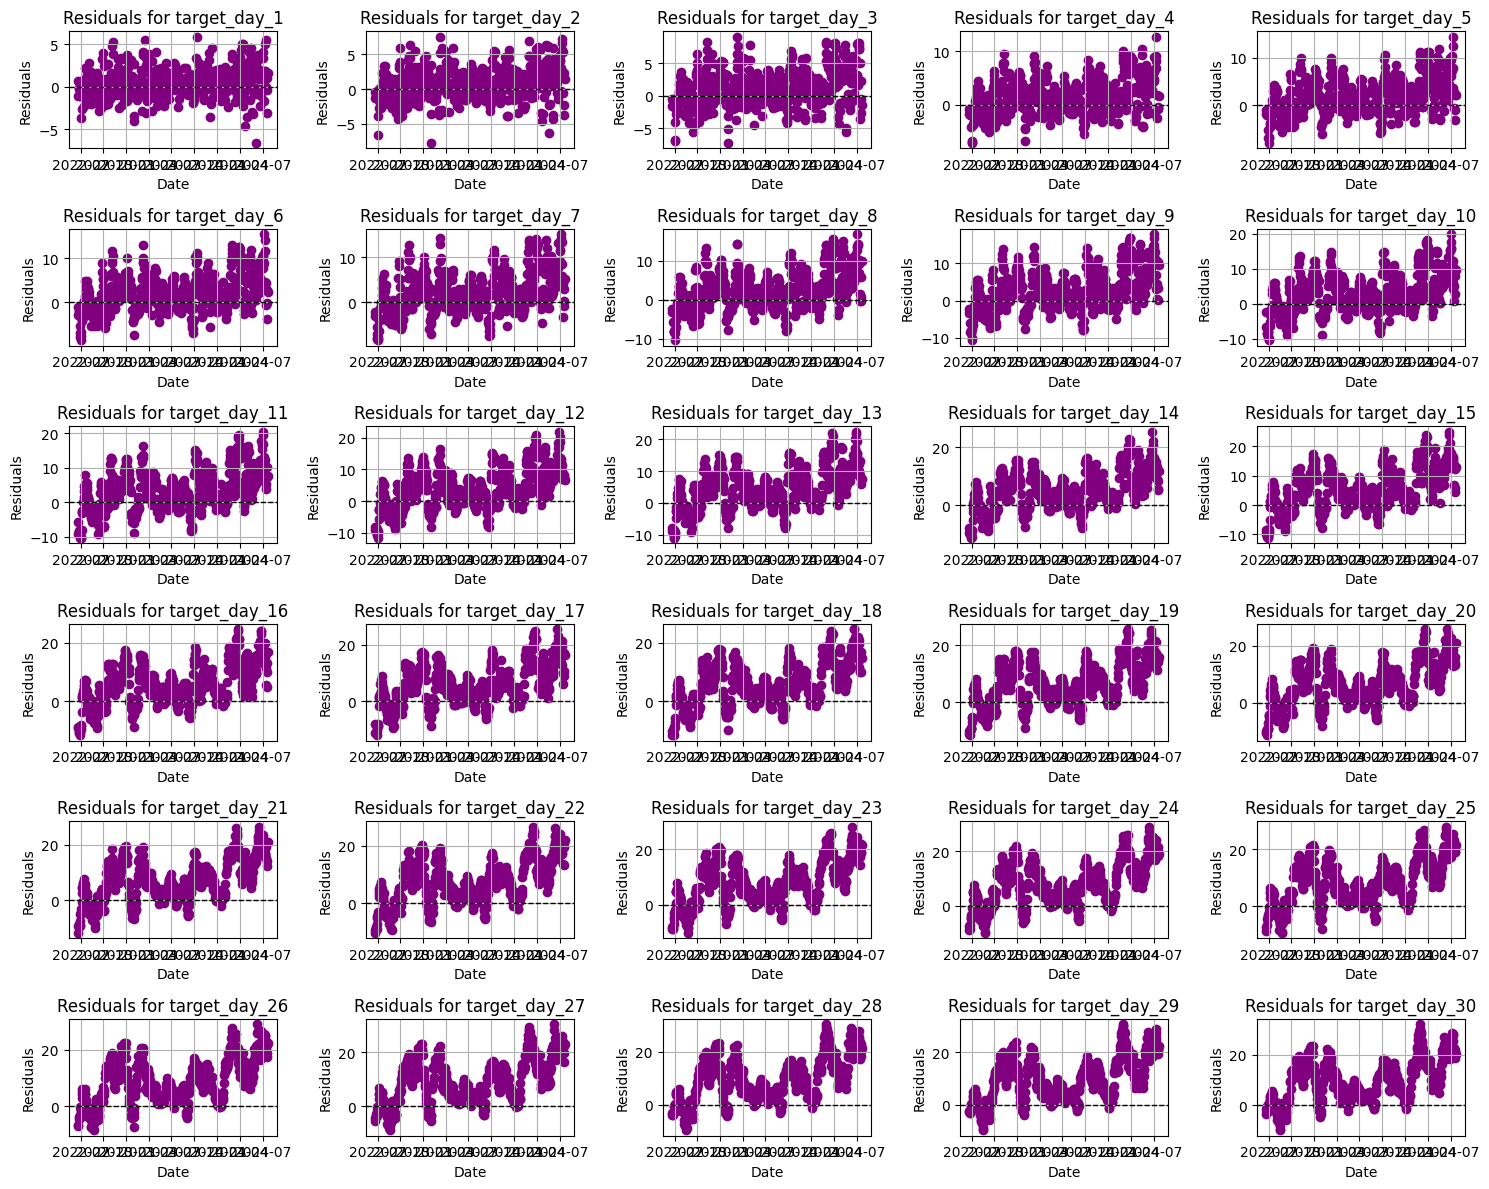

In [855]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, predictions))
mae = mean_absolute_error(y_test_dropped, predictions)
r2 = r2_score(y_test_dropped, predictions)

print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot residuals
residuals = y_test_dropped - predictions

# Assuming you have residuals as 'residuals' DataFrame with target_day_1, target_day_2, ..., target_day_30
# Create a plot for each target day
target_days = [f'target_day_{i}' for i in range(1, 31)]

# Set up the figure and axes for subplots
fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

# Loop over each target day and plot residuals for that day
for i, target_day in enumerate(target_days):
    residuals_day = residuals[target_day]
    
    axes[i].scatter(y_test_dropped.index, residuals_day, color='purple')
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i].set_title(f'Residuals for {target_day}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Residuals')
    axes[i].grid()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [864]:
predictions

array([[170.5977055 , 170.62276291, 170.6304892 , ..., 166.8011752 ,
        166.61696428, 166.4497353 ],
       [171.32764174, 171.34697418, 171.39643373, ..., 167.88787022,
        167.79113256, 167.59117876],
       [170.25259441, 170.35291821, 170.41972761, ..., 167.66157346,
        167.44729227, 167.32124584],
       ...,
       [224.87426443, 224.03673722, 223.01602295, ..., 212.22816961,
        212.53984669, 212.81262723],
       [220.82689594, 220.2327902 , 219.5058011 , ..., 210.543382  ,
        210.62405244, 210.85114681],
       [220.99987586, 220.31163052, 219.66484872, ..., 210.32822255,
        210.66343422, 210.73050213]])

In [ ]:
with open('modelResults/linear_reg_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(linear_reg_predictions_df, file)